## Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1,4,kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4,8,kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8,8,kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*64*64,500),
            nn.ReLU(inplace=True),

            nn.Linear(500,100),
            nn.ReLU(inplace=True),

            nn.Linear(100,20)
        )

    def forward_once(self,x):
        output = self.cnn1(x)
        output = output.view(output.size()[0],-1)
        output = self.fc1(output)
        return output

    def forward(self,input1,input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2  


#定义对比损失函数
class ContrastiveLoss(torch.nn.Module):
    def __init__(self,margin=2):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
  
    def forward(self,output1,output2,label):
        euclidean_distance = F.pairwise_distance(output1,output2,keepdim=True)
        loss_constrastive = torch.mean((1-label)*torch.pow(euclidean_distance,2)+
                        (label)*torch.pow(torch.clamp(self.margin-euclidean_distance,min=0.0),2))
        return loss_constrastive


## Utils

In [2]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def loss_plot(iteration,loss,i):
    # 绘制损失变化图
    plt.figure()
    plt.plot(iteration,loss)
    plt.savefig('loss' + str(i+1) + '.jpg')
    # plt.show()

# 生成图像路径txt文件
def generate_img_txt(root):
    f = open('images.txt','w')
    for i in range(1,6):
        if i == 1:
            for j in range(900):
                if j < 9:
                    img_path = root+str(i)+'/images00000'+str(j+1)+'.jpg'
                elif j < 99:
                    img_path = root+str(i)+'/images0000'+str(j+1)+'.jpg'
                else:
                    img_path = root+str(i)+'/images000'+str(j+1)+'.jpg'
                f.write(img_path+'\n')
        else:
            for j in range(4500):
                if j < 9:
                    img_path = root+str(i)+'/img00000'+str(j+1)+'_RGB.jpg'
                elif j < 99:
                    img_path = root+str(i)+'/img0000'+str(j+1)+'_RGB.jpg'
                elif j < 999:
                    img_path = root+str(i)+'/img000'+str(j+1)+'_RGB.jpg'
                else:
                    img_path = root+str(i)+'/img00'+str(j+1)+'_RGB.jpg'
                f.write(img_path+'\n')
    f.close()

# 降维加聚类
def feature2label(features, dim_reduction='pca'):
    if dim_reduction == 'tsne':
        tsne = TSNE(n_components=2)
        X = tsne.fit_transform(features)
    else:
        pca = PCA(n_components=2)
        X = pca.fit_transform(features)
    label = KMeans(5).fit_predict(features)
    return X,label

# 预训练模型提取特征
def pretrain(dataloader):
    pre_model = models.resnet18(pretrained=True).to(device)
    result = []
    for img in dataloader:
        pre_model.fc = nn.ReLU()
        pre_model.eval()
        with torch.no_grad():
            img = img.to(device)
            feature = pre_model(img).data.cpu().numpy().squeeze()
            result.append(feature)
    return result

def cluster_plot(X,labels,i):
    colors = ['#0000FF','#1E90FF','#00BFFF','#87CEEB','yellow']
    plt.figure()
    for label in np.unique(labels):
        X_labeled = X[labels==label]
        plt.scatter(X_labeled[:,0],X_labeled[:,1],c=colors[label])
    plt.savefig('kmeans'+str(i+1)+'.jpg')
    # plt.show()


## Dataset

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset
import random
from PIL import Image
import linecache

# 孪生神经网络所用的数据集
class SiameseDataset(Dataset):

    def __init__(self, txt, labellist, transform=None):
        self.transform = transform
        self.txt = txt
        self.labellist = labellist
  
    def __getitem__(self, index):
        idx0 = random.randint(0,self.__len__()-1)
        label0 = self.labellist[idx0]
        line0 = linecache.getline(self.txt, idx0+1).strip('\n')
        img0 = Image.open(line0)

        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                idx1 = random.randint(1,self.__len__())
                if self.labellist[idx1-1] == label0:
                    break
        else:
            idx1 = random.randint(1,self.__len__())
        label1 = self.labellist[idx1-1]
        line1 = linecache.getline(self.txt, idx1).strip('\n')
        img1 = Image.open(line1)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        return img0, img1, torch.from_numpy(np.array([int(label0!=label1)],dtype=np.float32))

    def __len__(self):
        with open(self.txt, 'r') as f:
            num = len(f.readlines())
        return num

# 孪生网络提取特征的Dataset
class Eval_Dataset(Dataset):

    def __init__(self, txt, transform=None, initial=False):
        self.transform = transform
        self.txt = txt
        self.initial = initial

    def __getitem__(self, index):
        line = linecache.getline(self.txt, index+1).strip('\n')
        img = Image.open(line)

        if not self.initial:
            img = img.convert("L")

        if self.transform is not None:
            img = self.transform(img)
        
        return img

    def __len__(self):
        with open(self.txt, 'r') as f:
            num = len(f.readlines())
        return num  
        

## Main

In [4]:
import torch
from torch import optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_EPOCHS = 40

def pre_work():
    init_dataset = Eval_Dataset('images.txt',transforms.ToTensor(),initial=True)
    init_dataloader = DataLoader(init_dataset)

    init_feature = pretrain(init_dataloader)
    init_labellist = feature2label(init_feature)
    return init_labellist[1]

def train(labellist,batch_size,train_number_epochs,learning_rate):

    train_dataset = SiameseDataset('images.txt',labellist,transforms.ToTensor())
    train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

    # 训练
    net = SiameseNetwork().to(device) #定义模型且移至GPU
    criterion = ContrastiveLoss() #定义损失函数
    optimizer = optim.Adam(net.parameters(),lr=learning_rate)

    counter = []
    loss_history = []
    iteration_number = 0

    # 开始训练
    for epoch in range(0,train_number_epochs):
        total_loss = 0
        for i,data in enumerate(train_dataloader):
            img0,img1,label = data
            img0,img1,label = img0.to(device),img1.to(device),label.to(device)

            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            total_loss += loss_contrastive.item()
            optimizer.step()
            if i%10 == 0:
                iteration_number += 10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
        print("Epoch number: {} , Current loss: {:.4f}".format(epoch+1,total_loss/(i+1)))

    torch.save(net.state_dict(),"param.pth")
    return counter, loss_history


def eval():
    eval_dataset = Eval_Dataset('images.txt',transforms.ToTensor())
    eval_dataloader = DataLoader(eval_dataset)

    net = SiameseNetwork().to(device)
    net.load_state_dict(torch.load("param.pth"))
    features = []

    for img in eval_dataloader:
        with torch.no_grad():
            img = img.to(device)
            output = net.forward_once(img).data.cpu().numpy().squeeze()
            features.append(output)
    
    X ,new_labellist = feature2label(features)
    return X, new_labellist


if __name__ == '__main__':
    print("----------------------Preparing-----------------------")
    generate_img_txt(root='5flc_snr_0_1_2/')
    init_labellist = pre_work()
    for i in range(1):
        print("Round: %d" % (i+1))
        if i==0:
            labellist = init_labellist
        else:
            labellist = new_labellist
        print("----------------------Training-----------------------")
        counter, loss_history = train(labellist,BATCH_SIZE,NUM_EPOCHS,0.0005)
        loss_plot(counter, loss_history, i)
        print("----------------------Clustering-----------------------")
        X, new_labellist = eval()
        cluster_plot(X, new_labellist, i)


----------------------Preparing-----------------------
Round: 1
----------------------Training-----------------------
Epoch number: 1 , Current loss: 0.8878
Epoch number: 2 , Current loss: 0.7959
Epoch number: 3 , Current loss: 0.7382
Epoch number: 4 , Current loss: 0.6813
Epoch number: 5 , Current loss: 0.6067
Epoch number: 6 , Current loss: 0.5189
Epoch number: 7 , Current loss: 0.4397
Epoch number: 8 , Current loss: 0.3607
Epoch number: 9 , Current loss: 0.2975
Epoch number: 10 , Current loss: 0.2352
Epoch number: 11 , Current loss: 0.1852
Epoch number: 12 , Current loss: 0.1596
Epoch number: 13 , Current loss: 0.1241
Epoch number: 14 , Current loss: 0.1022
Epoch number: 15 , Current loss: 0.0891
Epoch number: 16 , Current loss: 0.0793
Epoch number: 17 , Current loss: 0.0700
Epoch number: 18 , Current loss: 0.0648
Epoch number: 19 , Current loss: 0.0585
Epoch number: 20 , Current loss: 0.0509
Epoch number: 21 , Current loss: 0.0479
Epoch number: 22 , Current loss: 0.0441
Epoch numbe

KeyboardInterrupt: 

## New data

In [19]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib

In [6]:
newdata = np.load('./mrc_np/micrograph_001.npy')
print(newdata.shape)

(200, 1, 200, 200)


In [30]:
type(newdata)

numpy.ndarray

In [11]:
img = Image.open('./5flc_snr_0_1_2/1/images000001.jpg')

In [13]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

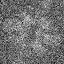

In [15]:
img.convert('L')

(1, 200, 200)
(200, 200)
<class 'PIL.Image.Image'>


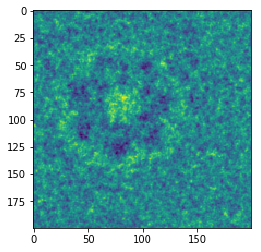

In [32]:
temp = newdata[10,:,:,:]
print(temp.shape)
temp = np.squeeze(temp)
temp = np.reshape(temp, [200,200])
print(temp.shape)
img = Image.fromarray(temp)
plt.imshow(temp)
print(type(img))
img = img.convert('RGB')

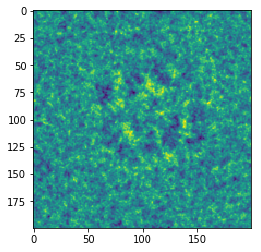

In [14]:
plt.imshow(temp)
plt.savefig('show1.jpg')

In [33]:
matplotlib.image.imsave('./3.png', temp)

## save the data as jpg

In [22]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib

In [26]:
strlist = []
for i in range(1,51):
    if i < 10:
        s = 'micrograph_00' + str(i) + '.npy'
    else:
        s = 'micrograph_0' + str(i) + '.npy'
    strlist.append(s)

In [28]:
root = './mrc_np/'

In [34]:
count = 0
for i in strlist:
    r = root + i
    newdata = np.load('./mrc_np/micrograph_001.npy')
    print('--------------------------------------')
    print(str(i), ' has ', str(newdata.shape[0]), ' images.')
    for j in range(newdata.shape[0]):
        temp = newdata[j,:,:,:]
        temp = np.squeeze(temp)
        temp = np.reshape(temp, [200,200])
        count += 1
        name = './datanew/' + str(count) + '.png'
        matplotlib.image.imsave(name, temp)
        print(str(j), ' is ', ' completed! Total: ', str(newdata.shape[0]))

--------------------------------------
micrograph_001.npy  has  200  images.
0  is   completed! Total:  200
1  is   completed! Total:  200
2  is   completed! Total:  200
3  is   completed! Total:  200
4  is   completed! Total:  200
5  is   completed! Total:  200
6  is   completed! Total:  200
7  is   completed! Total:  200
8  is   completed! Total:  200
9  is   completed! Total:  200
10  is   completed! Total:  200
11  is   completed! Total:  200
12  is   completed! Total:  200
13  is   completed! Total:  200
14  is   completed! Total:  200
15  is   completed! Total:  200
16  is   completed! Total:  200
17  is   completed! Total:  200
18  is   completed! Total:  200
19  is   completed! Total:  200
20  is   completed! Total:  200
21  is   completed! Total:  200
22  is   completed! Total:  200
23  is   completed! Total:  200
24  is   completed! Total:  200
25  is   completed! Total:  200
26  is   completed! Total:  200
27  is   completed! Total:  200
28  is   completed! Total:  200
29  i

57  is   completed! Total:  200
58  is   completed! Total:  200
59  is   completed! Total:  200
60  is   completed! Total:  200
61  is   completed! Total:  200
62  is   completed! Total:  200
63  is   completed! Total:  200
64  is   completed! Total:  200
65  is   completed! Total:  200
66  is   completed! Total:  200
67  is   completed! Total:  200
68  is   completed! Total:  200
69  is   completed! Total:  200
70  is   completed! Total:  200
71  is   completed! Total:  200
72  is   completed! Total:  200
73  is   completed! Total:  200
74  is   completed! Total:  200
75  is   completed! Total:  200
76  is   completed! Total:  200
77  is   completed! Total:  200
78  is   completed! Total:  200
79  is   completed! Total:  200
80  is   completed! Total:  200
81  is   completed! Total:  200
82  is   completed! Total:  200
83  is   completed! Total:  200
84  is   completed! Total:  200
85  is   completed! Total:  200
86  is   completed! Total:  200
87  is   completed! Total:  200
88  is  

113  is   completed! Total:  200
114  is   completed! Total:  200
115  is   completed! Total:  200
116  is   completed! Total:  200
117  is   completed! Total:  200
118  is   completed! Total:  200
119  is   completed! Total:  200
120  is   completed! Total:  200
121  is   completed! Total:  200
122  is   completed! Total:  200
123  is   completed! Total:  200
124  is   completed! Total:  200
125  is   completed! Total:  200
126  is   completed! Total:  200
127  is   completed! Total:  200
128  is   completed! Total:  200
129  is   completed! Total:  200
130  is   completed! Total:  200
131  is   completed! Total:  200
132  is   completed! Total:  200
133  is   completed! Total:  200
134  is   completed! Total:  200
135  is   completed! Total:  200
136  is   completed! Total:  200
137  is   completed! Total:  200
138  is   completed! Total:  200
139  is   completed! Total:  200
140  is   completed! Total:  200
141  is   completed! Total:  200
142  is   completed! Total:  200
143  is   

164  is   completed! Total:  200
165  is   completed! Total:  200
166  is   completed! Total:  200
167  is   completed! Total:  200
168  is   completed! Total:  200
169  is   completed! Total:  200
170  is   completed! Total:  200
171  is   completed! Total:  200
172  is   completed! Total:  200
173  is   completed! Total:  200
174  is   completed! Total:  200
175  is   completed! Total:  200
176  is   completed! Total:  200
177  is   completed! Total:  200
178  is   completed! Total:  200
179  is   completed! Total:  200
180  is   completed! Total:  200
181  is   completed! Total:  200
182  is   completed! Total:  200
183  is   completed! Total:  200
184  is   completed! Total:  200
185  is   completed! Total:  200
186  is   completed! Total:  200
187  is   completed! Total:  200
188  is   completed! Total:  200
189  is   completed! Total:  200
190  is   completed! Total:  200
191  is   completed! Total:  200
192  is   completed! Total:  200
193  is   completed! Total:  200
194  is   

16  is   completed! Total:  200
17  is   completed! Total:  200
18  is   completed! Total:  200
19  is   completed! Total:  200
20  is   completed! Total:  200
21  is   completed! Total:  200
22  is   completed! Total:  200
23  is   completed! Total:  200
24  is   completed! Total:  200
25  is   completed! Total:  200
26  is   completed! Total:  200
27  is   completed! Total:  200
28  is   completed! Total:  200
29  is   completed! Total:  200
30  is   completed! Total:  200
31  is   completed! Total:  200
32  is   completed! Total:  200
33  is   completed! Total:  200
34  is   completed! Total:  200
35  is   completed! Total:  200
36  is   completed! Total:  200
37  is   completed! Total:  200
38  is   completed! Total:  200
39  is   completed! Total:  200
40  is   completed! Total:  200
41  is   completed! Total:  200
42  is   completed! Total:  200
43  is   completed! Total:  200
44  is   completed! Total:  200
45  is   completed! Total:  200
46  is   completed! Total:  200
47  is  

67  is   completed! Total:  200
68  is   completed! Total:  200
69  is   completed! Total:  200
70  is   completed! Total:  200
71  is   completed! Total:  200
72  is   completed! Total:  200
73  is   completed! Total:  200
74  is   completed! Total:  200
75  is   completed! Total:  200
76  is   completed! Total:  200
77  is   completed! Total:  200
78  is   completed! Total:  200
79  is   completed! Total:  200
80  is   completed! Total:  200
81  is   completed! Total:  200
82  is   completed! Total:  200
83  is   completed! Total:  200
84  is   completed! Total:  200
85  is   completed! Total:  200
86  is   completed! Total:  200
87  is   completed! Total:  200
88  is   completed! Total:  200
89  is   completed! Total:  200
90  is   completed! Total:  200
91  is   completed! Total:  200
92  is   completed! Total:  200
93  is   completed! Total:  200
94  is   completed! Total:  200
95  is   completed! Total:  200
96  is   completed! Total:  200
97  is   completed! Total:  200
98  is  

120  is   completed! Total:  200
121  is   completed! Total:  200
122  is   completed! Total:  200
123  is   completed! Total:  200
124  is   completed! Total:  200
125  is   completed! Total:  200
126  is   completed! Total:  200
127  is   completed! Total:  200
128  is   completed! Total:  200
129  is   completed! Total:  200
130  is   completed! Total:  200
131  is   completed! Total:  200
132  is   completed! Total:  200
133  is   completed! Total:  200
134  is   completed! Total:  200
135  is   completed! Total:  200
136  is   completed! Total:  200
137  is   completed! Total:  200
138  is   completed! Total:  200
139  is   completed! Total:  200
140  is   completed! Total:  200
141  is   completed! Total:  200
142  is   completed! Total:  200
143  is   completed! Total:  200
144  is   completed! Total:  200
145  is   completed! Total:  200
146  is   completed! Total:  200
147  is   completed! Total:  200
148  is   completed! Total:  200
149  is   completed! Total:  200
150  is   

172  is   completed! Total:  200
173  is   completed! Total:  200
174  is   completed! Total:  200
175  is   completed! Total:  200
176  is   completed! Total:  200
177  is   completed! Total:  200
178  is   completed! Total:  200
179  is   completed! Total:  200
180  is   completed! Total:  200
181  is   completed! Total:  200
182  is   completed! Total:  200
183  is   completed! Total:  200
184  is   completed! Total:  200
185  is   completed! Total:  200
186  is   completed! Total:  200
187  is   completed! Total:  200
188  is   completed! Total:  200
189  is   completed! Total:  200
190  is   completed! Total:  200
191  is   completed! Total:  200
192  is   completed! Total:  200
193  is   completed! Total:  200
194  is   completed! Total:  200
195  is   completed! Total:  200
196  is   completed! Total:  200
197  is   completed! Total:  200
198  is   completed! Total:  200
199  is   completed! Total:  200
--------------------------------------
micrograph_010.npy  has  200  images.

24  is   completed! Total:  200
25  is   completed! Total:  200
26  is   completed! Total:  200
27  is   completed! Total:  200
28  is   completed! Total:  200
29  is   completed! Total:  200
30  is   completed! Total:  200
31  is   completed! Total:  200
32  is   completed! Total:  200
33  is   completed! Total:  200
34  is   completed! Total:  200
35  is   completed! Total:  200
36  is   completed! Total:  200
37  is   completed! Total:  200
38  is   completed! Total:  200
39  is   completed! Total:  200
40  is   completed! Total:  200
41  is   completed! Total:  200
42  is   completed! Total:  200
43  is   completed! Total:  200
44  is   completed! Total:  200
45  is   completed! Total:  200
46  is   completed! Total:  200
47  is   completed! Total:  200
48  is   completed! Total:  200
49  is   completed! Total:  200
50  is   completed! Total:  200
51  is   completed! Total:  200
52  is   completed! Total:  200
53  is   completed! Total:  200
54  is   completed! Total:  200
55  is  

82  is   completed! Total:  200
83  is   completed! Total:  200
84  is   completed! Total:  200
85  is   completed! Total:  200
86  is   completed! Total:  200
87  is   completed! Total:  200
88  is   completed! Total:  200
89  is   completed! Total:  200
90  is   completed! Total:  200
91  is   completed! Total:  200
92  is   completed! Total:  200
93  is   completed! Total:  200
94  is   completed! Total:  200
95  is   completed! Total:  200
96  is   completed! Total:  200
97  is   completed! Total:  200
98  is   completed! Total:  200
99  is   completed! Total:  200
100  is   completed! Total:  200
101  is   completed! Total:  200
102  is   completed! Total:  200
103  is   completed! Total:  200
104  is   completed! Total:  200
105  is   completed! Total:  200
106  is   completed! Total:  200
107  is   completed! Total:  200
108  is   completed! Total:  200
109  is   completed! Total:  200
110  is   completed! Total:  200
111  is   completed! Total:  200
112  is   completed! Total: 

137  is   completed! Total:  200
138  is   completed! Total:  200
139  is   completed! Total:  200
140  is   completed! Total:  200
141  is   completed! Total:  200
142  is   completed! Total:  200
143  is   completed! Total:  200
144  is   completed! Total:  200
145  is   completed! Total:  200
146  is   completed! Total:  200
147  is   completed! Total:  200
148  is   completed! Total:  200
149  is   completed! Total:  200
150  is   completed! Total:  200
151  is   completed! Total:  200
152  is   completed! Total:  200
153  is   completed! Total:  200
154  is   completed! Total:  200
155  is   completed! Total:  200
156  is   completed! Total:  200
157  is   completed! Total:  200
158  is   completed! Total:  200
159  is   completed! Total:  200
160  is   completed! Total:  200
161  is   completed! Total:  200
162  is   completed! Total:  200
163  is   completed! Total:  200
164  is   completed! Total:  200
165  is   completed! Total:  200
166  is   completed! Total:  200
167  is   

191  is   completed! Total:  200
192  is   completed! Total:  200
193  is   completed! Total:  200
194  is   completed! Total:  200
195  is   completed! Total:  200
196  is   completed! Total:  200
197  is   completed! Total:  200
198  is   completed! Total:  200
199  is   completed! Total:  200
--------------------------------------
micrograph_015.npy  has  200  images.
0  is   completed! Total:  200
1  is   completed! Total:  200
2  is   completed! Total:  200
3  is   completed! Total:  200
4  is   completed! Total:  200
5  is   completed! Total:  200
6  is   completed! Total:  200
7  is   completed! Total:  200
8  is   completed! Total:  200
9  is   completed! Total:  200
10  is   completed! Total:  200
11  is   completed! Total:  200
12  is   completed! Total:  200
13  is   completed! Total:  200
14  is   completed! Total:  200
15  is   completed! Total:  200
16  is   completed! Total:  200
17  is   completed! Total:  200
18  is   completed! Total:  200
19  is   completed! Total:  

47  is   completed! Total:  200
48  is   completed! Total:  200
49  is   completed! Total:  200
50  is   completed! Total:  200
51  is   completed! Total:  200
52  is   completed! Total:  200
53  is   completed! Total:  200
54  is   completed! Total:  200
55  is   completed! Total:  200
56  is   completed! Total:  200
57  is   completed! Total:  200
58  is   completed! Total:  200
59  is   completed! Total:  200
60  is   completed! Total:  200
61  is   completed! Total:  200
62  is   completed! Total:  200
63  is   completed! Total:  200
64  is   completed! Total:  200
65  is   completed! Total:  200
66  is   completed! Total:  200
67  is   completed! Total:  200
68  is   completed! Total:  200
69  is   completed! Total:  200
70  is   completed! Total:  200
71  is   completed! Total:  200
72  is   completed! Total:  200
73  is   completed! Total:  200
74  is   completed! Total:  200
75  is   completed! Total:  200
76  is   completed! Total:  200
77  is   completed! Total:  200
78  is  

103  is   completed! Total:  200
104  is   completed! Total:  200
105  is   completed! Total:  200
106  is   completed! Total:  200
107  is   completed! Total:  200
108  is   completed! Total:  200
109  is   completed! Total:  200
110  is   completed! Total:  200
111  is   completed! Total:  200
112  is   completed! Total:  200
113  is   completed! Total:  200
114  is   completed! Total:  200
115  is   completed! Total:  200
116  is   completed! Total:  200
117  is   completed! Total:  200
118  is   completed! Total:  200
119  is   completed! Total:  200
120  is   completed! Total:  200
121  is   completed! Total:  200
122  is   completed! Total:  200
123  is   completed! Total:  200
124  is   completed! Total:  200
125  is   completed! Total:  200
126  is   completed! Total:  200
127  is   completed! Total:  200
128  is   completed! Total:  200
129  is   completed! Total:  200
130  is   completed! Total:  200
131  is   completed! Total:  200
132  is   completed! Total:  200
133  is   

155  is   completed! Total:  200
156  is   completed! Total:  200
157  is   completed! Total:  200
158  is   completed! Total:  200
159  is   completed! Total:  200
160  is   completed! Total:  200
161  is   completed! Total:  200
162  is   completed! Total:  200
163  is   completed! Total:  200
164  is   completed! Total:  200
165  is   completed! Total:  200
166  is   completed! Total:  200
167  is   completed! Total:  200
168  is   completed! Total:  200
169  is   completed! Total:  200
170  is   completed! Total:  200
171  is   completed! Total:  200
172  is   completed! Total:  200
173  is   completed! Total:  200
174  is   completed! Total:  200
175  is   completed! Total:  200
176  is   completed! Total:  200
177  is   completed! Total:  200
178  is   completed! Total:  200
179  is   completed! Total:  200
180  is   completed! Total:  200
181  is   completed! Total:  200
182  is   completed! Total:  200
183  is   completed! Total:  200
184  is   completed! Total:  200
185  is   

9  is   completed! Total:  200
10  is   completed! Total:  200
11  is   completed! Total:  200
12  is   completed! Total:  200
13  is   completed! Total:  200
14  is   completed! Total:  200
15  is   completed! Total:  200
16  is   completed! Total:  200
17  is   completed! Total:  200
18  is   completed! Total:  200
19  is   completed! Total:  200
20  is   completed! Total:  200
21  is   completed! Total:  200
22  is   completed! Total:  200
23  is   completed! Total:  200
24  is   completed! Total:  200
25  is   completed! Total:  200
26  is   completed! Total:  200
27  is   completed! Total:  200
28  is   completed! Total:  200
29  is   completed! Total:  200
30  is   completed! Total:  200
31  is   completed! Total:  200
32  is   completed! Total:  200
33  is   completed! Total:  200
34  is   completed! Total:  200
35  is   completed! Total:  200
36  is   completed! Total:  200
37  is   completed! Total:  200
38  is   completed! Total:  200
39  is   completed! Total:  200
40  is   

62  is   completed! Total:  200
63  is   completed! Total:  200
64  is   completed! Total:  200
65  is   completed! Total:  200
66  is   completed! Total:  200
67  is   completed! Total:  200
68  is   completed! Total:  200
69  is   completed! Total:  200
70  is   completed! Total:  200
71  is   completed! Total:  200
72  is   completed! Total:  200
73  is   completed! Total:  200
74  is   completed! Total:  200
75  is   completed! Total:  200
76  is   completed! Total:  200
77  is   completed! Total:  200
78  is   completed! Total:  200
79  is   completed! Total:  200
80  is   completed! Total:  200
81  is   completed! Total:  200
82  is   completed! Total:  200
83  is   completed! Total:  200
84  is   completed! Total:  200
85  is   completed! Total:  200
86  is   completed! Total:  200
87  is   completed! Total:  200
88  is   completed! Total:  200
89  is   completed! Total:  200
90  is   completed! Total:  200
91  is   completed! Total:  200
92  is   completed! Total:  200
93  is  

117  is   completed! Total:  200
118  is   completed! Total:  200
119  is   completed! Total:  200
120  is   completed! Total:  200
121  is   completed! Total:  200
122  is   completed! Total:  200
123  is   completed! Total:  200
124  is   completed! Total:  200
125  is   completed! Total:  200
126  is   completed! Total:  200
127  is   completed! Total:  200
128  is   completed! Total:  200
129  is   completed! Total:  200
130  is   completed! Total:  200
131  is   completed! Total:  200
132  is   completed! Total:  200
133  is   completed! Total:  200
134  is   completed! Total:  200
135  is   completed! Total:  200
136  is   completed! Total:  200
137  is   completed! Total:  200
138  is   completed! Total:  200
139  is   completed! Total:  200
140  is   completed! Total:  200
141  is   completed! Total:  200
142  is   completed! Total:  200
143  is   completed! Total:  200
144  is   completed! Total:  200
145  is   completed! Total:  200
146  is   completed! Total:  200
147  is   

168  is   completed! Total:  200
169  is   completed! Total:  200
170  is   completed! Total:  200
171  is   completed! Total:  200
172  is   completed! Total:  200
173  is   completed! Total:  200
174  is   completed! Total:  200
175  is   completed! Total:  200
176  is   completed! Total:  200
177  is   completed! Total:  200
178  is   completed! Total:  200
179  is   completed! Total:  200
180  is   completed! Total:  200
181  is   completed! Total:  200
182  is   completed! Total:  200
183  is   completed! Total:  200
184  is   completed! Total:  200
185  is   completed! Total:  200
186  is   completed! Total:  200
187  is   completed! Total:  200
188  is   completed! Total:  200
189  is   completed! Total:  200
190  is   completed! Total:  200
191  is   completed! Total:  200
192  is   completed! Total:  200
193  is   completed! Total:  200
194  is   completed! Total:  200
195  is   completed! Total:  200
196  is   completed! Total:  200
197  is   completed! Total:  200
198  is   

19  is   completed! Total:  200
20  is   completed! Total:  200
21  is   completed! Total:  200
22  is   completed! Total:  200
23  is   completed! Total:  200
24  is   completed! Total:  200
25  is   completed! Total:  200
26  is   completed! Total:  200
27  is   completed! Total:  200
28  is   completed! Total:  200
29  is   completed! Total:  200
30  is   completed! Total:  200
31  is   completed! Total:  200
32  is   completed! Total:  200
33  is   completed! Total:  200
34  is   completed! Total:  200
35  is   completed! Total:  200
36  is   completed! Total:  200
37  is   completed! Total:  200
38  is   completed! Total:  200
39  is   completed! Total:  200
40  is   completed! Total:  200
41  is   completed! Total:  200
42  is   completed! Total:  200
43  is   completed! Total:  200
44  is   completed! Total:  200
45  is   completed! Total:  200
46  is   completed! Total:  200
47  is   completed! Total:  200
48  is   completed! Total:  200
49  is   completed! Total:  200
50  is  

72  is   completed! Total:  200
73  is   completed! Total:  200
74  is   completed! Total:  200
75  is   completed! Total:  200
76  is   completed! Total:  200
77  is   completed! Total:  200
78  is   completed! Total:  200
79  is   completed! Total:  200
80  is   completed! Total:  200
81  is   completed! Total:  200
82  is   completed! Total:  200
83  is   completed! Total:  200
84  is   completed! Total:  200
85  is   completed! Total:  200
86  is   completed! Total:  200
87  is   completed! Total:  200
88  is   completed! Total:  200
89  is   completed! Total:  200
90  is   completed! Total:  200
91  is   completed! Total:  200
92  is   completed! Total:  200
93  is   completed! Total:  200
94  is   completed! Total:  200
95  is   completed! Total:  200
96  is   completed! Total:  200
97  is   completed! Total:  200
98  is   completed! Total:  200
99  is   completed! Total:  200
100  is   completed! Total:  200
101  is   completed! Total:  200
102  is   completed! Total:  200
103  

126  is   completed! Total:  200
127  is   completed! Total:  200
128  is   completed! Total:  200
129  is   completed! Total:  200
130  is   completed! Total:  200
131  is   completed! Total:  200
132  is   completed! Total:  200
133  is   completed! Total:  200
134  is   completed! Total:  200
135  is   completed! Total:  200
136  is   completed! Total:  200
137  is   completed! Total:  200
138  is   completed! Total:  200
139  is   completed! Total:  200
140  is   completed! Total:  200
141  is   completed! Total:  200
142  is   completed! Total:  200
143  is   completed! Total:  200
144  is   completed! Total:  200
145  is   completed! Total:  200
146  is   completed! Total:  200
147  is   completed! Total:  200
148  is   completed! Total:  200
149  is   completed! Total:  200
150  is   completed! Total:  200
151  is   completed! Total:  200
152  is   completed! Total:  200
153  is   completed! Total:  200
154  is   completed! Total:  200
155  is   completed! Total:  200
156  is   

181  is   completed! Total:  200
182  is   completed! Total:  200
183  is   completed! Total:  200
184  is   completed! Total:  200
185  is   completed! Total:  200
186  is   completed! Total:  200
187  is   completed! Total:  200
188  is   completed! Total:  200
189  is   completed! Total:  200
190  is   completed! Total:  200
191  is   completed! Total:  200
192  is   completed! Total:  200
193  is   completed! Total:  200
194  is   completed! Total:  200
195  is   completed! Total:  200
196  is   completed! Total:  200
197  is   completed! Total:  200
198  is   completed! Total:  200
199  is   completed! Total:  200
--------------------------------------
micrograph_029.npy  has  200  images.
0  is   completed! Total:  200
1  is   completed! Total:  200
2  is   completed! Total:  200
3  is   completed! Total:  200
4  is   completed! Total:  200
5  is   completed! Total:  200
6  is   completed! Total:  200
7  is   completed! Total:  200
8  is   completed! Total:  200
9  is   completed

31  is   completed! Total:  200
32  is   completed! Total:  200
33  is   completed! Total:  200
34  is   completed! Total:  200
35  is   completed! Total:  200
36  is   completed! Total:  200
37  is   completed! Total:  200
38  is   completed! Total:  200
39  is   completed! Total:  200
40  is   completed! Total:  200
41  is   completed! Total:  200
42  is   completed! Total:  200
43  is   completed! Total:  200
44  is   completed! Total:  200
45  is   completed! Total:  200
46  is   completed! Total:  200
47  is   completed! Total:  200
48  is   completed! Total:  200
49  is   completed! Total:  200
50  is   completed! Total:  200
51  is   completed! Total:  200
52  is   completed! Total:  200
53  is   completed! Total:  200
54  is   completed! Total:  200
55  is   completed! Total:  200
56  is   completed! Total:  200
57  is   completed! Total:  200
58  is   completed! Total:  200
59  is   completed! Total:  200
60  is   completed! Total:  200
61  is   completed! Total:  200
62  is  

89  is   completed! Total:  200
90  is   completed! Total:  200
91  is   completed! Total:  200
92  is   completed! Total:  200
93  is   completed! Total:  200
94  is   completed! Total:  200
95  is   completed! Total:  200
96  is   completed! Total:  200
97  is   completed! Total:  200
98  is   completed! Total:  200
99  is   completed! Total:  200
100  is   completed! Total:  200
101  is   completed! Total:  200
102  is   completed! Total:  200
103  is   completed! Total:  200
104  is   completed! Total:  200
105  is   completed! Total:  200
106  is   completed! Total:  200
107  is   completed! Total:  200
108  is   completed! Total:  200
109  is   completed! Total:  200
110  is   completed! Total:  200
111  is   completed! Total:  200
112  is   completed! Total:  200
113  is   completed! Total:  200
114  is   completed! Total:  200
115  is   completed! Total:  200
116  is   completed! Total:  200
117  is   completed! Total:  200
118  is   completed! Total:  200
119  is   completed! 

143  is   completed! Total:  200
144  is   completed! Total:  200
145  is   completed! Total:  200
146  is   completed! Total:  200
147  is   completed! Total:  200
148  is   completed! Total:  200
149  is   completed! Total:  200
150  is   completed! Total:  200
151  is   completed! Total:  200
152  is   completed! Total:  200
153  is   completed! Total:  200
154  is   completed! Total:  200
155  is   completed! Total:  200
156  is   completed! Total:  200
157  is   completed! Total:  200
158  is   completed! Total:  200
159  is   completed! Total:  200
160  is   completed! Total:  200
161  is   completed! Total:  200
162  is   completed! Total:  200
163  is   completed! Total:  200
164  is   completed! Total:  200
165  is   completed! Total:  200
166  is   completed! Total:  200
167  is   completed! Total:  200
168  is   completed! Total:  200
169  is   completed! Total:  200
170  is   completed! Total:  200
171  is   completed! Total:  200
172  is   completed! Total:  200
173  is   

194  is   completed! Total:  200
195  is   completed! Total:  200
196  is   completed! Total:  200
197  is   completed! Total:  200
198  is   completed! Total:  200
199  is   completed! Total:  200
--------------------------------------
micrograph_034.npy  has  200  images.
0  is   completed! Total:  200
1  is   completed! Total:  200
2  is   completed! Total:  200
3  is   completed! Total:  200
4  is   completed! Total:  200
5  is   completed! Total:  200
6  is   completed! Total:  200
7  is   completed! Total:  200
8  is   completed! Total:  200
9  is   completed! Total:  200
10  is   completed! Total:  200
11  is   completed! Total:  200
12  is   completed! Total:  200
13  is   completed! Total:  200
14  is   completed! Total:  200
15  is   completed! Total:  200
16  is   completed! Total:  200
17  is   completed! Total:  200
18  is   completed! Total:  200
19  is   completed! Total:  200
20  is   completed! Total:  200
21  is   completed! Total:  200
22  is   completed! Total:  200

50  is   completed! Total:  200
51  is   completed! Total:  200
52  is   completed! Total:  200
53  is   completed! Total:  200
54  is   completed! Total:  200
55  is   completed! Total:  200
56  is   completed! Total:  200
57  is   completed! Total:  200
58  is   completed! Total:  200
59  is   completed! Total:  200
60  is   completed! Total:  200
61  is   completed! Total:  200
62  is   completed! Total:  200
63  is   completed! Total:  200
64  is   completed! Total:  200
65  is   completed! Total:  200
66  is   completed! Total:  200
67  is   completed! Total:  200
68  is   completed! Total:  200
69  is   completed! Total:  200
70  is   completed! Total:  200
71  is   completed! Total:  200
72  is   completed! Total:  200
73  is   completed! Total:  200
74  is   completed! Total:  200
75  is   completed! Total:  200
76  is   completed! Total:  200
77  is   completed! Total:  200
78  is   completed! Total:  200
79  is   completed! Total:  200
80  is   completed! Total:  200
81  is  

109  is   completed! Total:  200
110  is   completed! Total:  200
111  is   completed! Total:  200
112  is   completed! Total:  200
113  is   completed! Total:  200
114  is   completed! Total:  200
115  is   completed! Total:  200
116  is   completed! Total:  200
117  is   completed! Total:  200
118  is   completed! Total:  200
119  is   completed! Total:  200
120  is   completed! Total:  200
121  is   completed! Total:  200
122  is   completed! Total:  200
123  is   completed! Total:  200
124  is   completed! Total:  200
125  is   completed! Total:  200
126  is   completed! Total:  200
127  is   completed! Total:  200
128  is   completed! Total:  200
129  is   completed! Total:  200
130  is   completed! Total:  200
131  is   completed! Total:  200
132  is   completed! Total:  200
133  is   completed! Total:  200
134  is   completed! Total:  200
135  is   completed! Total:  200
136  is   completed! Total:  200
137  is   completed! Total:  200
138  is   completed! Total:  200
139  is   

160  is   completed! Total:  200
161  is   completed! Total:  200
162  is   completed! Total:  200
163  is   completed! Total:  200
164  is   completed! Total:  200
165  is   completed! Total:  200
166  is   completed! Total:  200
167  is   completed! Total:  200
168  is   completed! Total:  200
169  is   completed! Total:  200
170  is   completed! Total:  200
171  is   completed! Total:  200
172  is   completed! Total:  200
173  is   completed! Total:  200
174  is   completed! Total:  200
175  is   completed! Total:  200
176  is   completed! Total:  200
177  is   completed! Total:  200
178  is   completed! Total:  200
179  is   completed! Total:  200
180  is   completed! Total:  200
181  is   completed! Total:  200
182  is   completed! Total:  200
183  is   completed! Total:  200
184  is   completed! Total:  200
185  is   completed! Total:  200
186  is   completed! Total:  200
187  is   completed! Total:  200
188  is   completed! Total:  200
189  is   completed! Total:  200
190  is   

13  is   completed! Total:  200
14  is   completed! Total:  200
15  is   completed! Total:  200
16  is   completed! Total:  200
17  is   completed! Total:  200
18  is   completed! Total:  200
19  is   completed! Total:  200
20  is   completed! Total:  200
21  is   completed! Total:  200
22  is   completed! Total:  200
23  is   completed! Total:  200
24  is   completed! Total:  200
25  is   completed! Total:  200
26  is   completed! Total:  200
27  is   completed! Total:  200
28  is   completed! Total:  200
29  is   completed! Total:  200
30  is   completed! Total:  200
31  is   completed! Total:  200
32  is   completed! Total:  200
33  is   completed! Total:  200
34  is   completed! Total:  200
35  is   completed! Total:  200
36  is   completed! Total:  200
37  is   completed! Total:  200
38  is   completed! Total:  200
39  is   completed! Total:  200
40  is   completed! Total:  200
41  is   completed! Total:  200
42  is   completed! Total:  200
43  is   completed! Total:  200
44  is  

68  is   completed! Total:  200
69  is   completed! Total:  200
70  is   completed! Total:  200
71  is   completed! Total:  200
72  is   completed! Total:  200
73  is   completed! Total:  200
74  is   completed! Total:  200
75  is   completed! Total:  200
76  is   completed! Total:  200
77  is   completed! Total:  200
78  is   completed! Total:  200
79  is   completed! Total:  200
80  is   completed! Total:  200
81  is   completed! Total:  200
82  is   completed! Total:  200
83  is   completed! Total:  200
84  is   completed! Total:  200
85  is   completed! Total:  200
86  is   completed! Total:  200
87  is   completed! Total:  200
88  is   completed! Total:  200
89  is   completed! Total:  200
90  is   completed! Total:  200
91  is   completed! Total:  200
92  is   completed! Total:  200
93  is   completed! Total:  200
94  is   completed! Total:  200
95  is   completed! Total:  200
96  is   completed! Total:  200
97  is   completed! Total:  200
98  is   completed! Total:  200
99  is  

120  is   completed! Total:  200
121  is   completed! Total:  200
122  is   completed! Total:  200
123  is   completed! Total:  200
124  is   completed! Total:  200
125  is   completed! Total:  200
126  is   completed! Total:  200
127  is   completed! Total:  200
128  is   completed! Total:  200
129  is   completed! Total:  200
130  is   completed! Total:  200
131  is   completed! Total:  200
132  is   completed! Total:  200
133  is   completed! Total:  200
134  is   completed! Total:  200
135  is   completed! Total:  200
136  is   completed! Total:  200
137  is   completed! Total:  200
138  is   completed! Total:  200
139  is   completed! Total:  200
140  is   completed! Total:  200
141  is   completed! Total:  200
142  is   completed! Total:  200
143  is   completed! Total:  200
144  is   completed! Total:  200
145  is   completed! Total:  200
146  is   completed! Total:  200
147  is   completed! Total:  200
148  is   completed! Total:  200
149  is   completed! Total:  200
150  is   

171  is   completed! Total:  200
172  is   completed! Total:  200
173  is   completed! Total:  200
174  is   completed! Total:  200
175  is   completed! Total:  200
176  is   completed! Total:  200
177  is   completed! Total:  200
178  is   completed! Total:  200
179  is   completed! Total:  200
180  is   completed! Total:  200
181  is   completed! Total:  200
182  is   completed! Total:  200
183  is   completed! Total:  200
184  is   completed! Total:  200
185  is   completed! Total:  200
186  is   completed! Total:  200
187  is   completed! Total:  200
188  is   completed! Total:  200
189  is   completed! Total:  200
190  is   completed! Total:  200
191  is   completed! Total:  200
192  is   completed! Total:  200
193  is   completed! Total:  200
194  is   completed! Total:  200
195  is   completed! Total:  200
196  is   completed! Total:  200
197  is   completed! Total:  200
198  is   completed! Total:  200
199  is   completed! Total:  200
--------------------------------------
micr

24  is   completed! Total:  200
25  is   completed! Total:  200
26  is   completed! Total:  200
27  is   completed! Total:  200
28  is   completed! Total:  200
29  is   completed! Total:  200
30  is   completed! Total:  200
31  is   completed! Total:  200
32  is   completed! Total:  200
33  is   completed! Total:  200
34  is   completed! Total:  200
35  is   completed! Total:  200
36  is   completed! Total:  200
37  is   completed! Total:  200
38  is   completed! Total:  200
39  is   completed! Total:  200
40  is   completed! Total:  200
41  is   completed! Total:  200
42  is   completed! Total:  200
43  is   completed! Total:  200
44  is   completed! Total:  200
45  is   completed! Total:  200
46  is   completed! Total:  200
47  is   completed! Total:  200
48  is   completed! Total:  200
49  is   completed! Total:  200
50  is   completed! Total:  200
51  is   completed! Total:  200
52  is   completed! Total:  200
53  is   completed! Total:  200
54  is   completed! Total:  200
55  is  

76  is   completed! Total:  200
77  is   completed! Total:  200
78  is   completed! Total:  200
79  is   completed! Total:  200
80  is   completed! Total:  200
81  is   completed! Total:  200
82  is   completed! Total:  200
83  is   completed! Total:  200
84  is   completed! Total:  200
85  is   completed! Total:  200
86  is   completed! Total:  200
87  is   completed! Total:  200
88  is   completed! Total:  200
89  is   completed! Total:  200
90  is   completed! Total:  200
91  is   completed! Total:  200
92  is   completed! Total:  200
93  is   completed! Total:  200
94  is   completed! Total:  200
95  is   completed! Total:  200
96  is   completed! Total:  200
97  is   completed! Total:  200
98  is   completed! Total:  200
99  is   completed! Total:  200
100  is   completed! Total:  200
101  is   completed! Total:  200
102  is   completed! Total:  200
103  is   completed! Total:  200
104  is   completed! Total:  200
105  is   completed! Total:  200
106  is   completed! Total:  200
1

132  is   completed! Total:  200
133  is   completed! Total:  200
134  is   completed! Total:  200
135  is   completed! Total:  200
136  is   completed! Total:  200
137  is   completed! Total:  200
138  is   completed! Total:  200
139  is   completed! Total:  200
140  is   completed! Total:  200
141  is   completed! Total:  200
142  is   completed! Total:  200
143  is   completed! Total:  200
144  is   completed! Total:  200
145  is   completed! Total:  200
146  is   completed! Total:  200
147  is   completed! Total:  200
148  is   completed! Total:  200
149  is   completed! Total:  200
150  is   completed! Total:  200
151  is   completed! Total:  200
152  is   completed! Total:  200
153  is   completed! Total:  200
154  is   completed! Total:  200
155  is   completed! Total:  200
156  is   completed! Total:  200
157  is   completed! Total:  200
158  is   completed! Total:  200
159  is   completed! Total:  200
160  is   completed! Total:  200
161  is   completed! Total:  200
162  is   

192  is   completed! Total:  200
193  is   completed! Total:  200
194  is   completed! Total:  200
195  is   completed! Total:  200
196  is   completed! Total:  200
197  is   completed! Total:  200
198  is   completed! Total:  200
199  is   completed! Total:  200
--------------------------------------
micrograph_048.npy  has  200  images.
0  is   completed! Total:  200
1  is   completed! Total:  200
2  is   completed! Total:  200
3  is   completed! Total:  200
4  is   completed! Total:  200
5  is   completed! Total:  200
6  is   completed! Total:  200
7  is   completed! Total:  200
8  is   completed! Total:  200
9  is   completed! Total:  200
10  is   completed! Total:  200
11  is   completed! Total:  200
12  is   completed! Total:  200
13  is   completed! Total:  200
14  is   completed! Total:  200
15  is   completed! Total:  200
16  is   completed! Total:  200
17  is   completed! Total:  200
18  is   completed! Total:  200
19  is   completed! Total:  200
20  is   completed! Total:  2

42  is   completed! Total:  200
43  is   completed! Total:  200
44  is   completed! Total:  200
45  is   completed! Total:  200
46  is   completed! Total:  200
47  is   completed! Total:  200
48  is   completed! Total:  200
49  is   completed! Total:  200
50  is   completed! Total:  200
51  is   completed! Total:  200
52  is   completed! Total:  200
53  is   completed! Total:  200
54  is   completed! Total:  200
55  is   completed! Total:  200
56  is   completed! Total:  200
57  is   completed! Total:  200
58  is   completed! Total:  200
59  is   completed! Total:  200
60  is   completed! Total:  200
61  is   completed! Total:  200
62  is   completed! Total:  200
63  is   completed! Total:  200
64  is   completed! Total:  200
65  is   completed! Total:  200
66  is   completed! Total:  200
67  is   completed! Total:  200
68  is   completed! Total:  200
69  is   completed! Total:  200
70  is   completed! Total:  200
71  is   completed! Total:  200
72  is   completed! Total:  200
73  is  

99  is   completed! Total:  200
100  is   completed! Total:  200
101  is   completed! Total:  200
102  is   completed! Total:  200
103  is   completed! Total:  200
104  is   completed! Total:  200
105  is   completed! Total:  200
106  is   completed! Total:  200
107  is   completed! Total:  200
108  is   completed! Total:  200
109  is   completed! Total:  200
110  is   completed! Total:  200
111  is   completed! Total:  200
112  is   completed! Total:  200
113  is   completed! Total:  200
114  is   completed! Total:  200
115  is   completed! Total:  200
116  is   completed! Total:  200
117  is   completed! Total:  200
118  is   completed! Total:  200
119  is   completed! Total:  200
120  is   completed! Total:  200
121  is   completed! Total:  200
122  is   completed! Total:  200
123  is   completed! Total:  200
124  is   completed! Total:  200
125  is   completed! Total:  200
126  is   completed! Total:  200
127  is   completed! Total:  200
128  is   completed! Total:  200
129  is   c

(200, 1, 200, 200)
